In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
from tqdm import tqdm
from collections import defaultdict

# Read Data From Scratch

In [ ]:
business = pd.read_json("/content/drive/MyDrive/yelp/yelp_academic_dataset_business.json", lines=True)
business = business[~business["categories"].isna()]
business = business[business["is_open"] == 1]

In [ ]:
restaurants = business[business['categories'].str.contains('Restaurants')]

del business
gc.collect()

0

In [47]:
def parse_data(source: pd.DataFrame):
  # setup an array for writing each row in the csv file
  rows = []
  # setup an array for headers we are not using strictly
  removed_header = ['name', 'address', 'latitude', 'longitude', 'is_open']
  # headers that can be directly used
  useful_header = ['business_id', 'city', 'state', 'postal_code', 'stars', 'review_count']
  # setup an array for headers we are adding
  business_data = source
  # append the initial keys as csv headers
  header = source.columns
  business_data = business_data.drop(columns=removed_header).reset_index(drop=True)
  orig_header = sorted(business_data.columns)

  days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
  attributes = ["RestaurantsTakeOut", 'RestaurantsReservations',
            'RestaurantsDelivery', 'Alcohol','RestaurantsPriceRange2',
            'OutdoorSeating','RestaurantsGoodForGroups',
            'HasTV', 'Caters', 'GoodForKids', 'BusinessAcceptsCreditCards',
            'WiFi']

  print('processing data in the business dataset...')
  # for every entry in the business data array
  final_features = useful_header.copy()
  final_features.extend(days_of_week)
  final_features.extend(attributes)

  for entry in tqdm(range(0, len(business_data))):
    row = []
    for item in useful_header:
      row.append(business_data.loc[entry, item])

    # iterate through the days of the week to extract the open and close times
    for time in days_of_week:
      flag = 0
      # if a time is available
      if business_data.loc[entry, 'hours'] is not None:
        if time in business_data.loc[entry, 'hours'].keys():
          # append the open time
          if "-" in business_data.loc[entry, 'hours'][time]:
            open_time, close_time = business_data.loc[entry, 'hours'][time].split('-')
            if open_time != close_time:
              flag = 1
              row.append(1)
      if flag == 0:
        row.append(0)

    # for each attribute that is not nested
    for attribute in attributes:
      # if there is an attribute
      if business_data.loc[entry, 'attributes'] is not None:
        if attribute in business_data.loc[entry, 'attributes'].keys():
          # if the attribute contains true
          if business_data.loc[entry, 'attributes'][attribute] == "none":
            row.append(np.nan)
          else:
            row.append(business_data.loc[entry, 'attributes'][attribute])
        else:
          # append NA for the attribute
          row.append(np.nan)
      else:
          row.append(np.nan)

    # remove stray text, such as "\n" form address
    # set up an array for the cleaned row entries
    row_clean = []
    # for every item in the row
    for item in row:
      # scan and replace for nasty text
      row_clean.append(str(item).replace('\n', ' '))
    # after all fields have been extracted and cleaned, append the row to the rows array for writing to csv
    rows.append(row_clean)

  new_df = pd.DataFrame(rows, columns=final_features)
  new_df.replace({"none": np.nan}, inplace=True)

  return new_df


In [ ]:
temp = parse_data(restaurants)

processing data in the business dataset...


100%|██████████| 34987/34987 [00:20<00:00, 1705.00it/s]


In [ ]:
# (temp=="nan").sum(axis=0)
temp

,business_id,city,state,postal_code,stars,review_count,Sunday,Monday,Tuesday,Wednesday,...,RestaurantsDelivery,Alcohol,RestaurantsPriceRange2,OutdoorSeating,RestaurantsGoodForGroups,HasTV,Caters,GoodForKids,BusinessAcceptsCreditCards,WiFi
0,MTSW4McQd7CbVtyjqoe9mw,Philadelphia,PA,19107,4.0,80,1,1,1,1,...,False,u'none',1,False,nan,nan,True,nan,False,u'free'
1,CF33F8-E6oudUQ46HnavjQ,Ashland City,TN,37015,2.0,6,1,0,1,1,...,True,u'none',1,True,True,True,False,True,True,u'no'
2,bBDDEgkFA1Otx9Lfe7BZUQ,Nashville,TN,37207,1.5,10,1,0,1,1,...,True,u'none',1,True,False,True,False,True,True,u'no'
3,eEOYSgkmpB90uNA7lDOMRA,Tampa Bay,FL,33602,4.0,10,1,1,1,1,...,nan,'none',nan,None,nan,nan,nan,nan,nan,nan
4,il_Ro8jwPlHresjw9EGmBg,Indianapolis,IN,46227,2.5,28,1,1,1,1,...,True,'none',1,False,True,True,nan,True,True,u'no'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34982,w_4xUt-1AyY2ZwKtnjW0Xg,Boise,ID,83702,4.5,998,1,0,1,1,...,None,u'full_bar',2,None,True,True,False,False,True,u'free'
34983,l9eLGG9ZKpLJzboZq-9LRQ,Clifton Heights,PA,19018,3.0,11,0,0,0,0,...,True,nan,1,nan,nan,nan,True,nan,True,nan
34984,cM6V90ExQD6KMSU3rRB5ZA,Boise,ID,83704,4.0,33,0,0,1,0,...,False,u'none',1,True,True,False,False,True,True,'free'
34985,WnT9NIzQgLlILjPT0kEcsQ,Philadelphia,PA,19147,4.5,35,1,1,1,0,...,True,u'none',2,False,True,True,True,True,True,u'free'


In [ ]:
user = pd.read_json("/content/drive/MyDrive/yelp/yelp_academic_dataset_user.json", lines=True)
user.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [ ]:
del user
gc.collect()

350

In [ ]:
review = pd.read_json("/content/drive/MyDrive/yelp/yelp_academic_dataset_review.json", lines=True)
review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [ ]:
restaurant_ids = restaurants["business_id"].unique()
review["year"] = pd.DatetimeIndex(review["date"]).year
review_sample = review[review["year"] >= 2019]
review_sample = review_sample[review_sample["business_id"].isin(restaurant_ids)]

In [ ]:
review_sample_out = review_sample.groupby('user_id').agg({'user_id':'size'}).rename(columns={'user_id':'Num_Visits'})

frequent_users = review_sample_out.query('Num_Visits >= 20').index
review_sample = review_sample[review_sample["user_id"].isin(frequent_users)]

In [ ]:
involved_user_ids, involved_business_ids = review_sample["user_id"].unique(), review_sample["business_id"].unique()

In [ ]:
involved_restaurants, involved_users = restaurants[restaurants["business_id"].isin(involved_business_ids)], user[user["user_id"].isin(involved_user_ids)]

## Split Train-Test Using Temporal Split

In [ ]:
review_sample["date"] = review_sample["date"].astype(str)
review_sample.drop(columns=["year"], inplace=True)

In [ ]:
review_test = review_sample.groupby("user_id").tail(5)
review_test_id = review_test["review_id"].unique()
review_train = review_sample[~review_sample["review_id"].isin(review_test_id)]

In [ ]:
assert review_train.shape[0] + review_test.shape[0] == review_sample.shape[0]

In [ ]:
review_train.shape, review_test.shape

((195455, 9), (29565, 9))

In [ ]:
review_train.reset_index(drop=True, inplace=True)
review_test.reset_index(drop=True, inplace=True)
involved_restaurants.reset_index(drop=True, inplace=True)
involved_users.reset_index(drop=True, inplace=True)

In [ ]:
involved_users_dict = involved_users.to_dict('records')
involved_restaurants_dict = involved_restaurants.to_dict('records')
review_train_dict = review_train.to_dict('records')
review_test_dict = review_test.to_dict('records')

In [ ]:
import json
with open("/content/drive/MyDrive/SampleYelpData/sample_reviews_train.json", "w") as outfile:
    json.dump(review_train_dict, outfile)
with open("/content/drive/MyDrive/SampleYelpData/sample_reviews_test.json", "w") as outfile:
    json.dump(review_test_dict, outfile)
with open("/content/drive/MyDrive/SampleYelpData/sample_users.json", "w") as outfile:
    json.dump(involved_users_dict, outfile)
with open("/content/drive/MyDrive/SampleYelpData/sample_business.json", "w") as outfile:
    json.dump(involved_restaurants_dict, outfile)

In [ ]:
del review
gc.collect()

391252

In [ ]:
temp = parse_data(involved_restaurants)

processing data in the business dataset...


100%|██████████| 28028/28028 [00:15<00:00, 1802.49it/s]


# Read Existing Processed Data

In [3]:
# review_sample.to_pickle("/content/drive/MyDrive/yelp/sample_reviews.pkl")
review_sample = pd.read_pickle("/content/drive/MyDrive/yelp/sample_reviews.pkl")

In [50]:
# involved_users.to_pickle("/content/drive/MyDrive/yelp/sample_users.pkl")
involved_users = pd.read_pickle("/content/drive/MyDrive/yelp/sample_users.pkl")

In [5]:
user_sample = involved_users

In [ ]:
# user_sample["starting_year"] = pd.DatetimeIndex(user_sample["yelping_since"]).year
# user_sample["elite_times"] = user_sample["elite"].apply(lambda x: len(x.split(",")))
# user_sample["friends_num"] = user_sample["friends"].apply(lambda x: len(x.split(",")))
# user_sample.drop(columns=["yelping_since", "name", "elite", "friends"], inplace=True)

In [ ]:
user_sample.reset_index(drop=True, inplace=True)
user_sample.to_pickle("/content/drive/MyDrive/yelp/sample_users.pkl")

In [ ]:
review_train.rename(columns={"stars": "review_stars"}, inplace=True)
review_test.rename(columns={"stars": "review_stars"}, inplace=True)
review_sample.rename(columns={"stars": "review_stars"}, inplace=True)

NameError: ignored

In [34]:
train_review.head()

,target,useful_x,funny_x,cool_x,review_count_x,useful_y,funny_y,cool_y,fans,average_stars,...,RestaurantsDelivery,Alcohol,RestaurantsPriceRange2,OutdoorSeating,RestaurantsGoodForGroups,HasTV,Caters,GoodForKids,BusinessAcceptsCreditCards,WiFi
0,3,1,1,1,1253,3099,922,2613,65,3.94,...,True,'full_bar',2,False,True,True,True,True,True,'free'
1,3,0,0,0,241,186,33,67,6,3.93,...,True,u'full_bar',2,True,True,True,True,False,True,u'free'
2,5,0,0,0,145,31,38,5,0,3.47,...,False,u'full_bar',2,False,True,True,nan,False,nan,u'no'
3,4,5,1,2,3184,12407,3331,8335,254,3.60,...,True,'full_bar',2,True,True,True,True,True,True,'free'
4,3,0,0,0,100,237,21,166,8,4.05,...,True,'beer_and_wine',1,True,True,True,True,True,True,'no'


In [ ]:
temp.rename(columns={"stars": "business_stars"}, inplace=True)

In [48]:
temp = parse_data(pd.read_json("/content/drive/MyDrive/SampleYelpData/sample_business.json"))

processing data in the business dataset...


100%|██████████| 28028/28028 [00:15<00:00, 1753.93it/s]


In [46]:
def merge_df(review, user, business):
  concat_df = pd.merge(review, user, on="user_id", how="left")
  concat_df = pd.merge(concat_df, business, on="business_id", how="left")
  return concat_df

In [51]:
review_train = pd.read_json("/content/drive/MyDrive/SampleYelpData/sample_reviews_train.json")
review_test = pd.read_json("/content/drive/MyDrive/SampleYelpData/sample_reviews_test.json")
review_sample = pd.concat([review_train, review_test], axis=0)

review_train.rename(columns={"stars": "review_stars"}, inplace=True)
review_test.rename(columns={"stars": "review_stars"}, inplace=True)
review_sample.rename(columns={"stars": "review_stars"}, inplace=True)

In [54]:
review_train = review_train[["review_id", "user_id", "business_id", "review_stars"]]
review_test = review_test[["review_id", "user_id", "business_id", "review_stars"]]
review_sample = review_sample[["review_id", "user_id", "business_id", "review_stars"]]

In [55]:
train_review = merge_df(review_train, user_sample, temp)
test_review = merge_df(review_test, user_sample, temp)
concat_df = merge_df(review_sample, user_sample, temp)

In [56]:
train_review.head()

,review_id,user_id,business_id,review_stars,review_count_x,useful,funny,cool,fans,average_stars,...,RestaurantsDelivery,Alcohol,RestaurantsPriceRange2,OutdoorSeating,RestaurantsGoodForGroups,HasTV,Caters,GoodForKids,BusinessAcceptsCreditCards,WiFi
0,KY8dRN_k2EoR_QujKAegTQ,ARFM4LrI_zxogm1L29ZKng,UmjITdXHhEF46ho6IhaGQg,3,1253,3099,922,2613,65,3.94,...,True,'full_bar',2,False,True,True,True,True,True,'free'
1,804egtW_PfFQYEc0vjvC-g,byiu5KFz0S5lEG_97_4WKA,Fe9WDVsrEM9H0X_aFDuYVA,3,241,186,33,67,6,3.93,...,True,u'full_bar',2,True,True,True,True,False,True,u'free'
2,7DyiNXV2yqecK_nc5chmSQ,OC5NfNnFunZusgzkwXUQEA,Iw7uhUS9D5gXESPr_DVHaA,5,145,31,38,5,0,3.47,...,False,u'full_bar',2,False,True,True,nan,False,nan,u'no'
3,uIfkITfSSgVoDYPiAjz6Mg,h7p-GuaHFGsiKCF4g6Bjqg,EERwPZdemE21aIwYsadjTg,4,3184,12407,3331,8335,254,3.60,...,True,'full_bar',2,True,True,True,True,True,True,'free'
4,CBQvjJ7mcGQ_zMFqocxIww,5KrbLFidQQZMeeAwrrDkdQ,bKgyXSQUGA8IHGt8ne5NuA,3,100,237,21,166,8,4.05,...,True,'beer_and_wine',1,True,True,True,True,True,True,'no'


In [5]:
# train_review.to_pickle("/content/drive/MyDrive/yelp/review_train.pkl")
# test_review.to_pickle("/content/drive/MyDrive/yelp/review_test.pkl")
train_review = pd.read_pickle("/content/drive/MyDrive/yelp/review_train.pkl")
test_review = pd.read_pickle("/content/drive/MyDrive/yelp/review_test.pkl")

In [6]:
train_review.rename(columns={"stars": "business_stars"}, inplace=True)
test_review.rename(columns={"stars": "business_stars"}, inplace=True)

In [7]:
concat_df = pd.concat([train_review, test_review], axis=0).reset_index(drop=True)
concat_df.rename(columns={"stars": "business_stars"}, inplace=True)

# WIDE AND DEEP

In [8]:
def processing_concat_df(concat_df):
  concat_df.rename(columns={"review_stars": "target"}, inplace=True)
  concat_df.drop(columns=[
      "review_id", "user_id", "business_id",
      "state", "postal_code"
      ], inplace=True)
  days_of_week = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
  for day in days_of_week:
      concat_df[day] = concat_df[day].astype(int)
  concat_df["business_stars"] = concat_df["business_stars"].astype(float)
  concat_df["review_count_y"] = concat_df["review_count_y"].astype(float)
  return concat_df

In [9]:
train_review = processing_concat_df(train_review)
test_review = processing_concat_df(test_review)
concat_df = processing_concat_df(concat_df)

In [10]:
train_review.head(3)

,target,review_count_x,useful,funny,cool,fans,average_stars,compliment_hot,compliment_more,compliment_profile,...,RestaurantsDelivery,Alcohol,RestaurantsPriceRange2,OutdoorSeating,RestaurantsGoodForGroups,HasTV,Caters,GoodForKids,BusinessAcceptsCreditCards,WiFi
0,3,1253,3099,922,2613,65,3.94,17,10,0,...,True,'full_bar',2,False,True,True,True,True,True,'free'
1,3,241,186,33,67,6,3.93,8,0,0,...,True,u'full_bar',2,True,True,True,True,False,True,u'free'
2,5,145,31,38,5,0,3.47,0,0,0,...,False,u'full_bar',2,False,True,True,nan,False,nan,u'no'


In [52]:
train_review.shape, test_review.shape

((195455, 43), (29565, 43))

In [11]:
import torch
from torch import nn, cat, mean

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
!pip install nvtabular

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.5/284.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.1/142.1 kB 8.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 9.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 10.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata

In [13]:
sparse_features = [
    "city",
    "RestaurantsTakeOut",
    'RestaurantsReservations',
    'RestaurantsDelivery',
    'Alcohol',
    'RestaurantsPriceRange2',
    'OutdoorSeating',
    'RestaurantsGoodForGroups',
    'HasTV',
    'Caters',
    'GoodForKids',
    'BusinessAcceptsCreditCards',
    'WiFi',
    'Sunday',
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday'
    ]

In [14]:
def build_sparse_features_idx_mapping(sparse_features, concat_df):
  sparce_features_to_idx = defaultdict(dict)
  idx_to_sparce_features = defaultdict(dict)
  for f in sparse_features:
    feature = list(concat_df[f].unique())
    feature_nums = len(feature)
    for i in range(feature_nums):
      sparce_features_to_idx[f][feature[i]] = i
      idx_to_sparce_features[f][i] = [feature[i]]
  return sparce_features_to_idx, idx_to_sparce_features

In [75]:
import json
with open("/content/drive/MyDrive/SampleYelpData/sparse_encoding_dict.json", "w") as outfile:
    json.dump(sparce_features_to_idx, outfile)

TypeError: ignored

In [15]:
sparce_features_to_idx, idx_to_sparce_features = build_sparse_features_idx_mapping(sparse_features, concat_df)

In [16]:
def encode_concat_df(concat_df, sparce_features_to_idx, sparse_features):
  encoded_concat_df = concat_df.copy()
  for f in sparse_features:
    encoded_concat_df[f] = encoded_concat_df[f].map(sparce_features_to_idx[f])
  return encoded_concat_df

In [17]:
encoded_concat_df = encode_concat_df(concat_df, sparce_features_to_idx, sparse_features)
encoded_train_review = encode_concat_df(train_review, sparce_features_to_idx, sparse_features)
encoded_test_review = encode_concat_df(test_review, sparce_features_to_idx, sparse_features)

In [18]:
def get_embedding_shape(sparse_features, concat_df):
  embedding_table_shapes = {}
  for f in sparse_features:
    if f != "city":
      embedding_table_shapes[f] = (len(concat_df[f].unique()), 16)
    else:
      embedding_table_shapes[f] = (len(concat_df[f].unique()), 128)
  return embedding_table_shapes

In [19]:
embedding_table_shapes = get_embedding_shape(sparse_features, concat_df)
emb_size = sum([i[1] for i in embedding_table_shapes.values()])
emb_size

432

In [20]:
from nvtabular.framework_utils.torch.layers import ConcatenatedEmbeddings

/usr/local/lib/python3.10/dist-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


In [21]:
wide_features = ["review_count_x", "review_count_y", 'compliment_hot',
       'compliment_more', 'compliment_profile',
       'compliment_cute', 'compliment_list', 'compliment_note',
       'compliment_plain', 'compliment_cool', 'compliment_funny',
       'compliment_writer', 'compliment_photos', 'starting_year']

In [22]:
dense_features = ["fans", "average_stars", "starting_year", "friends_num", "useful",
                  "funny", "cool", "elite_times", "business_stars"]

In [23]:
len(wide_features), len(dense_features), len(sparse_features)

(14, 9, 20)

In [24]:
class WideAndDeep(nn.Module):
    def __init__(
        self,
        embedding_table_shapes, # embeddings for sparse features
        wide_size,
        emb_size, # length of concat embeddings
        dense_feature_size, # length of dense features
        dropout=0.2, # dropout for embeddings
    ):
        super(WideAndDeep, self).__init__()
        self.initial_cat_layer = ConcatenatedEmbeddings(
            embedding_table_shapes, dropout=dropout
        )
        self.wide_linear_relu = nn.Sequential(
            nn.Linear(wide_size, 1),
        )
        self.deep_linear_relu_stack = nn.Sequential(
            nn.Linear(emb_size + dense_feature_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, wide_features, sparse_features, dense_features):
        wide_res = self.wide_linear_relu(wide_features)
        # get embeddings for sparse features
        concat_emb = self.initial_cat_layer(sparse_features)
        deep_input = torch.cat((concat_emb, dense_features), dim=1)
        deep_res = self.deep_linear_relu_stack(deep_input)
        total_res = wide_res + deep_res
        return total_res

In [54]:
model = WideAndDeep(embedding_table_shapes, 14, 432, 9)
model.to(device)

WideAndDeep(
  (initial_cat_layer): ConcatenatedEmbeddings(
    (embedding_layers): ModuleList(
      (0): Embedding(766, 128)
      (1-3): 3 x Embedding(4, 16)
      (4): Embedding(8, 16)
      (5): Embedding(6, 16)
      (6-11): 6 x Embedding(4, 16)
      (12): Embedding(8, 16)
      (13-19): 7 x Embedding(2, 16)
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (wide_linear_relu): Sequential(
    (0): Linear(in_features=14, out_features=1, bias=True)
  )
  (deep_linear_relu_stack): Sequential(
    (0): Linear(in_features=441, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [26]:
from torch.utils.data import Dataset, DataLoader

In [27]:
class YelpDataset(Dataset):

    def __init__(self, whole_data, wide, sparse, dense):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = whole_data
        self.wide = wide
        self.sparse = sparse
        self.dense = dense

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
      wide, sparse, dense = self.data.iloc[idx][self.wide], self.data.iloc[idx][self.sparse], self.data.iloc[idx][self.dense]
      t_wide = torch.tensor(wide.values).float()
      t_sparse = torch.tensor(sparse.values).long()
      t_dense = torch.tensor(dense.values).float()
      t_target = torch.tensor(self.data.iloc[idx]["target"]).float()

      return t_wide, t_sparse, t_dense, t_target

In [28]:
encoded_train_dataset = YelpDataset(encoded_train_review.iloc[:150000], wide_features, sparse_features, dense_features)
encoded_train_dataloader = DataLoader(encoded_train_dataset, batch_size=256, shuffle=True)

In [29]:
encoded_valid_dataset = YelpDataset(encoded_train_review.iloc[150000:], wide_features, sparse_features, dense_features)
encoded_valid_dataloader = DataLoader(encoded_valid_dataset, batch_size=256, shuffle=True)

In [30]:
encoded_test_dataset = YelpDataset(encoded_test_review, wide_features, sparse_features, dense_features)
encoded_test_dataloader = DataLoader(encoded_test_dataset, batch_size=256, shuffle=True)

In [55]:
model.load_state_dict(torch.load("/content/drive/MyDrive/yelp/TrainedModel128/model_27.pt"))

<All keys matched successfully>

In [32]:
train_loss_list = []
valid_loss_list = []

In [33]:
def train_model(model, train_dataloader, valid_dataloader, EPOCHS=30):
  loss_fn = nn.MSELoss(reduction="sum")
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  for t in range(20, EPOCHS):
      PATH = "/content/drive/MyDrive/yelp/TrainedModel128/model_{}.pt".format(t)
      train_num_data = 0
      valid_num_data = 0
      model.train()
      train_loss = 0
      valid_loss = 0

      for idx, data in enumerate(tqdm(train_dataloader)):
          # Move tensors to the configured device
          t_wide, t_sparse, t_dense, t_target = data
          train_num_data += t_wide.shape[0]
          t_wide, t_sparse, t_dense, t_target = t_wide.to(device), t_sparse.to(device), t_dense.to(device), t_target.to(device)

          # Forward pass
          pred_train = torch.flatten(model(t_wide, t_sparse, t_dense))
          loss_batch = loss_fn(pred_train, t_target)

          train_loss += loss_batch.item()

          # Backpropagation
          optimizer.zero_grad()
          loss_batch.backward()
          optimizer.step()

      for idx, data in enumerate(tqdm(valid_dataloader)):
          # Move tensors to the configured device
          t_wide, t_sparse, t_dense, t_target = data
          valid_num_data += t_wide.shape[0]
          t_wide, t_sparse, t_dense, t_target = t_wide.to(device), t_sparse.to(device), t_dense.to(device), t_target.to(device)

          # Forward pass
          with torch.no_grad():
            pred_train = torch.flatten(model(t_wide, t_sparse, t_dense))
            loss_batch = loss_fn(pred_train, t_target)

            valid_loss += loss_batch.item()


      print(f"Epoch {t}")
      train_rmse = round(np.sqrt(train_loss/train_num_data), 4)
      valid_rmse = round(np.sqrt(valid_loss/valid_num_data), 4)
      print(f"Train RMSE: {train_rmse}")
      train_loss_list.append(train_rmse)
      print(f"Valid RMSE: {valid_rmse}")
      valid_loss_list.append(valid_rmse)

      file = open('/content/drive/MyDrive/yelp/TrainedModel128/loss.txt', 'a')
      file.write(f'{train_rmse}\t{valid_rmse}\n')
      file.close()

      torch.save(model.state_dict(), PATH)

In [34]:
train_model(model, encoded_train_dataloader, encoded_valid_dataloader, EPOCHS=30)

100%|██████████| 178/178 [01:29<00:00,  1.99it/s]


Epoch 20
Train RMSE: 1.8455
Valid RMSE: 2.0616


100%|██████████| 178/178 [01:32<00:00,  1.92it/s]


Epoch 21
Train RMSE: 1.0699
Valid RMSE: 1.0331


100%|██████████| 178/178 [01:31<00:00,  1.95it/s]


Epoch 22
Train RMSE: 1.0566
Valid RMSE: 1.1741


100%|██████████| 178/178 [01:31<00:00,  1.95it/s]


Epoch 23
Train RMSE: 1.6813
Valid RMSE: 1.2496


100%|██████████| 178/178 [01:32<00:00,  1.93it/s]


Epoch 24
Train RMSE: 1.0351
Valid RMSE: 1.0235


100%|██████████| 178/178 [01:29<00:00,  1.99it/s]


Epoch 25
Train RMSE: 1.5403
Valid RMSE: 1.2506


100%|██████████| 178/178 [01:27<00:00,  2.05it/s]


Epoch 26
Train RMSE: 1.0352
Valid RMSE: 1.0218


100%|██████████| 178/178 [01:26<00:00,  2.05it/s]


Epoch 27
Train RMSE: 1.0311
Valid RMSE: 1.0188


100%|██████████| 178/178 [01:27<00:00,  2.04it/s]


Epoch 28
Train RMSE: 1.7963
Valid RMSE: 1.0348


 41%|████      | 241/586 [02:01<02:53,  1.99it/s]


KeyboardInterrupt: ignored

In [36]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

1208208

In [56]:
loss_fn = nn.MSELoss(reduction="sum")
test_num_data = 0
test_loss = 0
model.eval()
for idx, data in enumerate(tqdm(encoded_test_dataloader)):
  # Move tensors to the configured device
  t_wide, t_sparse, t_dense, t_target = data
  test_num_data += t_wide.shape[0]
  t_wide, t_sparse, t_dense, t_target = t_wide.to(device), t_sparse.to(device), t_dense.to(device), t_target.to(device)

  # Forward pass
  with torch.no_grad():
    pred_train = torch.flatten(model(t_wide, t_sparse, t_dense))
    loss_batch = loss_fn(pred_train, t_target)

    test_loss += loss_batch.item()


test_rmse = round(np.sqrt(test_loss/test_num_data), 4)
print(f"Test RMSE: {test_rmse}")

100%|██████████| 116/116 [00:57<00:00,  2.01it/s]

Test RMSE: 1.0341


In [69]:
# test_num_data = 0
test_loss = 0
target_pred = []
model.eval()
for idx, data in enumerate(tqdm(encoded_test_dataloader)):
  # Move tensors to the configured device
  t_wide, t_sparse, t_dense, t_target = data
  # test_num_data += t_wide.shape[0]
  t_wide, t_sparse, t_dense, t_target = t_wide.to(device), t_sparse.to(device), t_dense.to(device), t_target.to(device)

  # Forward pass
  with torch.no_grad():
    pred_train = torch.flatten(model(t_wide, t_sparse, t_dense))
    target_pred.append(np.dstack((pred_train.cpu().numpy(), t_target.cpu().numpy()))[0])
    # print(pred_train.cpu().numpy())
#     loss_batch = loss_fn(pred_train, t_target)

#     test_loss += loss_batch.item()


# test_rmse = round(np.sqrt(test_loss/test_num_data), 4)
# print(f"Test RMSE: {test_rmse}")

100%|██████████| 116/116 [00:58<00:00,  1.99it/s]


In [70]:
target_pred_array = np.concatenate(target_pred)
target_pred_df = pd.DataFrame(target_pred_array, columns=["pred", "target"])
id_target_pred_df = pd.concat([test_user_id, target_pred_df], axis=1)

In [71]:
from sklearn.metrics import ndcg_score
def helper(x):
  try:
    return ndcg_score(
        x["target"].values[np.newaxis, :],
        x["pred"].values[np.newaxis, :]
        )
  except:
    return np.nan

In [72]:
np.nanmean(id_target_pred_df.groupby("user_id").apply(
    lambda x: helper(x)
    ))

0.967290026770601

In [60]:
test_user_id = pd.read_json("/content/drive/MyDrive/SampleYelpData/sample_reviews_test.json")["user_id"]
train_valid_user_id = pd.read_json("/content/drive/MyDrive/SampleYelpData/sample_reviews_train.json")["user_id"]

In [61]:
train_user_id = train_valid_user_id.iloc[:150000]
valid_user_id = train_valid_user_id.iloc[150000:].reset_index(drop=True)

In [43]:
with open('/content/drive/MyDrive/yelp/TrainedModel128/loss.txt', 'r') as f:
  content = f.readlines()


In [44]:
train_loss_list = []
valid_loss_list = []

for line in content:
  train_loss_list.append(float(line.strip().split("\t")[0]))
  valid_loss_list.append(float(line.strip().split("\t")[1]))

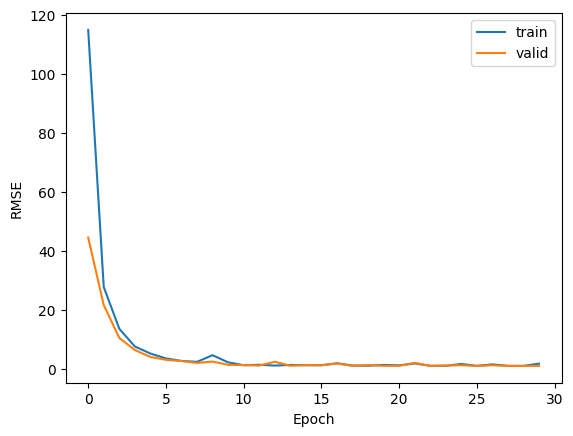

In [45]:
import matplotlib.pyplot as plt

plt.plot(train_loss_list, label="train")
plt.plot(valid_loss_list, label="valid")
plt.ylabel("RMSE")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [ ]:
def recommend_topK_restaurants(user_id, model, dataloader, k=5):
  model.eval()
